### Подключаем основные модули

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import warnings

pd.options.display.max_columns = 100
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from tqdm import tqdm
from dotenv import load_dotenv, find_dotenv
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from catboost import (CatBoostClassifier, Pool, sum_models, to_classifier)


from TextPreprocessor import TextPreprocessor

### Подключаемся к базе и загружаем основные таблицы

In [2]:
load_dotenv(find_dotenv())
DB_CONNECTION = os.getenv('DB_CONNECTION')

In [3]:
users = pd.read_sql(
    """
    SELECT *
    FROM public.user_data
    """,
    con=DB_CONNECTION
)
posts = pd.read_sql(
    """
    SELECT *
    FROM public.post_text_df
    """,
    con=DB_CONNECTION
)


<div class="alert alert-block">
<h2> Таблица user_data </h2>
<b><i> Cодержит информацию о всех пользователях соц.сети </i> </b>
</div>

| Field name |	Overview|
|------------|----------|
| age	| Возраст пользователя (в профиле)|
| city	| Город пользователя (в профиле)|
| country	| Страна пользователя (в профиле)|
| exp_group	| Экспериментальная группа: некоторая зашифрованная категория|
| gender	| Пол пользователя|
| id	| Уникальный идентификатор пользователя|
| os	| Операционная система устройства, с которого происходит пользование соц.сетью|
| source	|Пришел ли пользователь в приложение с органического трафика или с рекламы|

In [4]:
users.to_csv("../data/raw/user_raw.csv", sep=";", index=False)
users.head(5)

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


<div class="alert alert-block">
<h2> Таблица post_text_df </h2>
<b><i> Содержит информацию о постах: уникальный ID каждого поста с соответствующим ей текстом и топиком</i></b>
</div>

| Field name |	Overview|
|------------|----------|
| id	| Уникальный идентификатор поста |
| text	| Текстовое содержание поста |
| topic	| Основная тематика |

In [5]:
posts.to_csv("../data/raw/posts_raw.csv", sep=";", index=False)
posts.head(5)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


## Начинаем построение рекомандательной системы на контентной основе

<b>Таблица пользователей содержит и так достаточно информации, добавим лишь информацию об уже просмотренных постах, чтобы рекомендательная система не предлагала пользователям посты, которые уже они видели </b>

In [6]:
query = """
        SELECT user_id, STRING_AGG(DISTINCT cast(post_id as varchar(5)), ',') as viewed_posts
        FROM public.feed_data
        WHERE action!='like'
        GROUP BY user_id
        """

viewed_posts_by_users = pd.read_sql(query, DB_CONNECTION)


processed_users = pd.merge(users, viewed_posts_by_users, on="user_id")
processed_users.to_csv("../data/processed/users_processed.csv", sep=";", index=False)
del processed_users, viewed_posts_by_users

## Сгенерируем новые фичи на основе содержания текста
#### Для этого выполним следующую последовательность действий:
1. <b> Предварительная обработка текста </b>
1. <b> Преобразование обработанного текста в векторный формат эмбеддингов </b>
1. <b> Сокращение размерности векторного пространства с помощью метода главных компонент </b>
1. <b> Формирование кластеров на основе получившихся векторов  </b>

### 1. Предварительная обработка текста
<b> Для этого пункта в рамках данного проекта был разработан python-пакет TextPreprocessor. Он позволяет выполнять предварительную обработку как одного, так и списка текстов с возможностью параллельной обработки несколькими процессами. Метод transform экземпляра класса TextPreprocessor включает в себя следующий пайплайн: </b>
-  ***Удаление html тегов и url-ссылок.***
-  ***Расшифовка смыслового значения эмодзи и символьных смайлов.***
-  ***Приведение текста к нижнему регистру.***
-  ***Приведение различных дат к единому формату записи.***
-  ***Расшифровка смыслового значения некоторых символов (% = percent, $ = dollar).***
-  ***Расшифровка разговорных аббревиатур (asap = as soon as posible, b4 = before).***
-  ***Приведение различных чисел в текстовый формат.***
-  ***Удаление лишних пробелов.***
-  ***Избавление от пунктуационных символов и стоп-слов.***
-  ***Лемматизация.***





<b> Примеры использования можно найти </b>

In [7]:
from TextPreprocessor import TextPreprocessor
tp = TextPreprocessor(-1)
posts["new_text"]=np.squeeze(tp.transform(posts["text"]))

In [8]:
posts.head(5)

,post_id,text,topic,new_text
0,1,UK economy facing major risks\n\nThe UK manufa...,business,united kingdom economy face major risk united ...
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,aids climate davos agenda climate change fight...
2,3,Asian quake hits European shares\n\nShares in ...,business,asian quake hit european share share europe le...
3,4,India power shares jump on debut\n\nShares in ...,business,india power share jump debut share indias larg...
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,lacroix label buy united states firm luxury go...


### 2. Преобразование текста в векторный формат эмбеддингов
Для извлечения эмбеддингов из текста в будет применяться нейросетевая модель BERT  

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, tokenizer):
        self.text = X
        self.tokenizer = tokenizer

    def __len__(self):
        return self.text.shape[0]

    def __getitem__(self, index):
        output = self.text[index]
        output = self.tokenizer(output, return_tensors='pt', padding='max_length', truncation=True)
        return {k: v.reshape(-1) for k, v in output.items()}


eval_ds = CustomDataset(posts["new_text"].to_numpy(), tokenizer)
eval_dataloader = DataLoader(eval_ds, batch_size=16)

<b> На выходе данной модели мы имеем 4х-мерный массив следующей формы (13, batch_size, tokens_count, 768). </b>

<b> Рассмотрим эти измерения по порядку: </b>
1. <i>Колличество слоев модели + слой начальных значений, т.е. (12 + 1). </i>
1. <i>Количествo текстов в одном батче.</i>
1. <i>Колличестo токенов в одном тексте. </i>
1. <i>768 эмбеддингов на каждый токен. </i>

<b> Поскольку нас интересуют эмбеддинги для текста целиком, а не для каждого токена в отдельности, достаточно будет усреднить эмбеддинги по всем токенам в рамках одного текста. </b>
<div class="alert alert-block alert-warning">
<b> Кроме того, согласно  <a href="https://arxiv.org/pdf/1810.04805">работе</a> авторов модели BERT использование одного лишь последнего слоя модели не особо эффективно. Скомбинировав эмбеддинги разных слоев можно получить намного больше информации. </b>
</div>

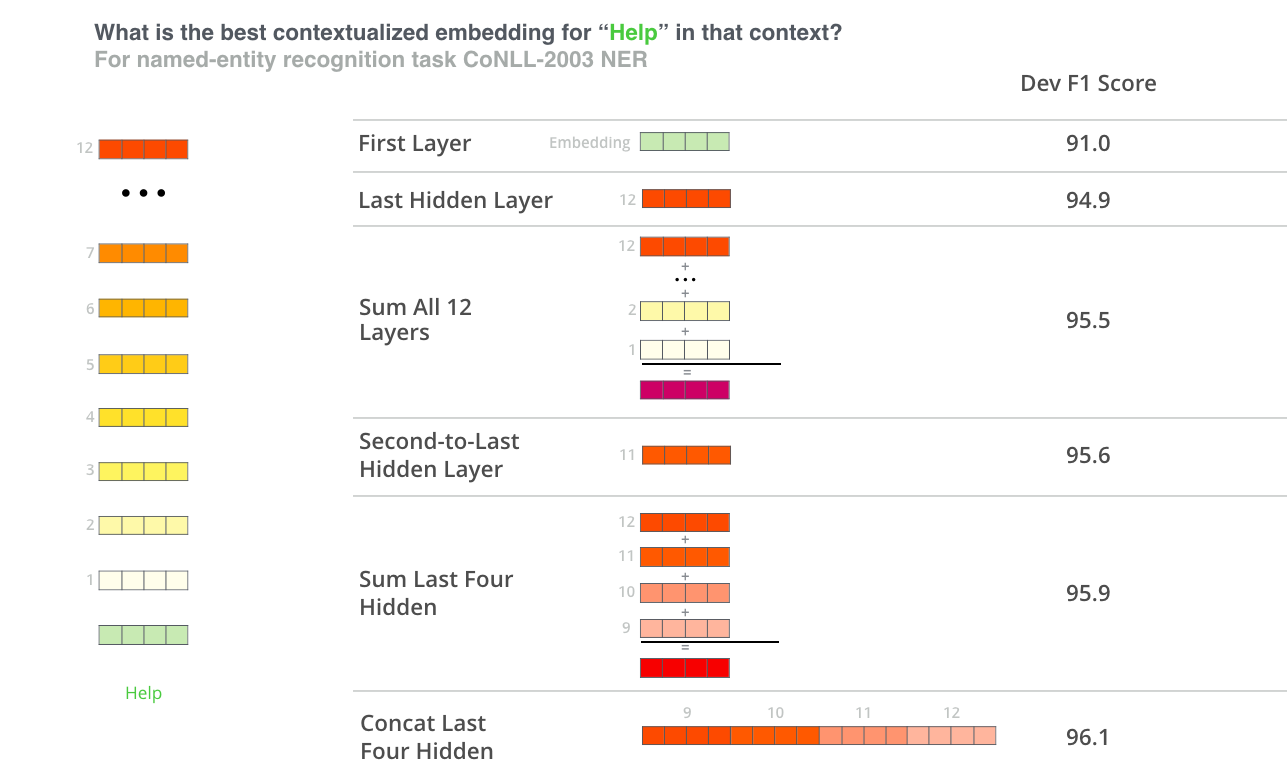


<b> Таким образом для получения векторного представления текстов в данном пет-проекте усреднялась сумма эмбеддингов последних 4-х слоев модели BERT</b>

<b> При чем усреднение велось с учетом attention маски, что позволило брать во внимание только те токены, которые непосредственно использовались при расчете эмбеддингов.</b>

In [11]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = torch.stack(model_output["hidden_states"], dim=0)
    token_embeddings = token_embeddings.permute(1,0,2,3)
    input_mask_expanded = attention_mask.unsqueeze(1).unsqueeze(-1).expand(token_embeddings.size()).float()

    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 2)
    sum_mask = torch.clamp(input_mask_expanded.sum(2), min=1e-9)
    mean_embeddings = sum_embeddings / sum_mask
    return torch.sum(mean_embeddings[:,-4:], dim=1)

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()

embeddings = torch.Tensor().to(device)

with torch.no_grad():
    for n_batch, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        embeddings = torch.cat([embeddings, mean_pooling(outputs, batch['attention_mask'])])
    embeddings = embeddings.cpu().numpy()

100%|██████████| 439/439 [01:03<00:00,  6.93it/s]


### 3. Сокращение размерности векторного пространства с помощью метода главных компонент
<b> Сокращение размерности пространства с 768 до 50 измерений при помощи метода главных компонент позволяет существенно снизить потребляемый объем оперативной памяти, не сильно потеряв при этом важной информации </b>

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


posts["MaxEmbedVal"] = embeddings.max(axis=1)
posts["MeanEmbedVal"] = embeddings.mean(axis=1)
posts["TotalEmbedVal"] = embeddings.sum(axis=1)

centered = embeddings - embeddings.mean(axis=0)
pca_processed = PCA(n_components=50, random_state=123).fit_transform(centered)


### 4. Формирование кластеров на основе получившихся векторов
<b> Построим новые фичи на основании 50-мерных эмбеддингов. Для этого проведем кластеризацию и рассчитаем расстояние до каждого класстера. </b>

In [14]:
kmeans = KMeans(n_clusters=24, max_iter=1000, random_state=123).fit(pca_processed)
posts["TextCluster"] = kmeans.labels_

distances = pd.DataFrame(kmeans.transform(pca_processed), columns=[f"DistanceTo{ith}thCluster" for ith in range(1, 25)])
posts = pd.concat((posts, distances), axis=1)

posts = posts.drop("new_text", axis=1)
posts.to_csv("../data/processed/posts_processed.csv", sep=";", index=False)
posts = posts.drop("text", axis=1)
posts

,post_id,topic,MaxEmbedVal,MeanEmbedVal,TotalEmbedVal,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster,DistanceTo21thCluster,DistanceTo22thCluster,DistanceTo23thCluster,DistanceTo24thCluster
0,1,business,4.529040,-0.124404,-95.542328,15,22.261896,13.099248,29.979940,29.314686,11.584602,23.699211,17.523638,28.899017,26.524326,16.389471,28.163010,26.970724,29.090849,24.082008,29.367706,8.182902,15.273962,24.258280,31.327581,23.627239,14.997159,15.891109,16.550526,29.358761
1,2,business,3.963311,-0.123789,-95.070030,1,21.667465,9.246825,28.268030,28.949413,10.702765,25.220810,12.119991,28.262722,26.601990,14.463403,28.478376,28.492235,29.742348,24.226330,28.344170,9.639972,13.498013,25.346054,30.563574,22.243814,11.562040,12.210733,16.452246,29.869322
2,3,business,4.646831,-0.128086,-98.369942,20,28.247566,13.754550,33.670731,34.201012,17.741068,32.423943,11.166720,33.859394,33.048340,16.014053,33.540329,31.418880,36.033497,29.550905,33.867146,13.325476,19.902006,32.375690,35.477528,26.711992,9.899107,18.405455,22.076370,36.392338
3,4,business,3.777473,-0.120015,-92.171524,15,18.750790,17.254704,24.374846,24.871334,10.941665,20.140112,21.206648,25.293903,22.719830,20.169605,24.327694,25.987120,24.003035,23.520620,22.433842,10.576833,15.184554,20.447374,27.431629,23.511738,19.964136,15.108402,15.997710,24.762014
4,5,business,3.626136,-0.118425,-90.950089,21,16.339979,16.456209,21.107237,22.971956,11.909149,20.609106,17.590576,21.958372,20.925869,17.989008,22.138956,25.140043,23.056032,22.039852,22.363489,11.970634,13.040865,20.073837,24.334553,20.287582,18.658018,11.771769,14.754152,23.978321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,movie,4.602031,-0.110159,-84.602371,8,12.517963,23.463678,24.194431,25.237495,19.984579,12.524867,26.564636,19.377472,11.537211,20.858797,23.408073,28.432268,23.450682,14.139665,25.001530,22.849693,18.898497,13.190039,24.401390,14.052781,26.790817,18.699106,15.105682,22.129658
7019,7316,movie,4.623341,-0.106823,-82.039810,13,19.194128,27.706921,25.586521,27.916269,24.569445,17.516874,31.465065,20.010107,14.854186,23.461533,25.374079,31.920916,25.393290,10.861662,26.740871,27.968054,25.208199,19.096138,24.438990,12.626614,30.111328,25.038980,20.189234,22.385719
7020,7317,movie,4.002336,-0.108711,-83.490013,8,10.722265,24.660456,19.818703,21.891216,20.107273,11.825687,28.041397,14.695100,9.275449,22.387812,19.430948,26.305750,19.200085,15.206617,21.712492,23.839039,19.895761,11.348854,20.348576,14.761512,28.314035,18.959126,15.277785,18.275955
7021,7318,movie,3.301220,-0.108124,-83.038994,17,10.190430,27.940901,21.747490,23.168945,22.546021,12.709871,31.111042,18.009644,10.544839,26.182886,21.968571,29.556379,18.968067,20.691496,23.047523,25.765505,21.887632,8.588717,24.107222,19.667923,31.741697,20.521711,17.472775,21.136528


### Визуализируем полученный результат - сопоставим темы с номерами кластеров 

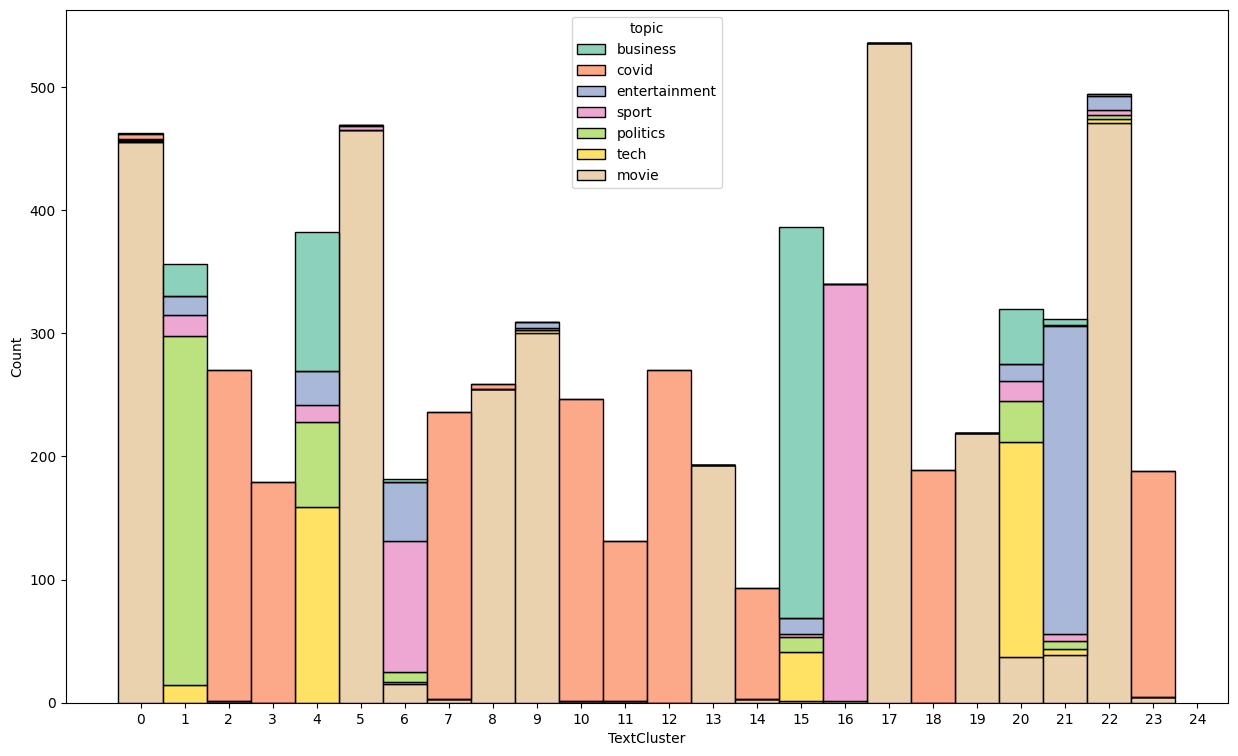

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,9))
ax = sns.histplot(posts, x='TextCluster', hue='topic',
             multiple='stack', palette='Set2', bins=24, binrange=(-0.5, 23.5))
_ = ax.set_xticks(range(0, 25))

### Подгружаем таблицу с информацией о просмотренных постах и лайках.
<div class="alert alert-block">
<h2>Таблица feed_data </h2>
<b> <i>Содержит информацию о действиях пользователей с указанием времени действия. </i></b>
</div>

| Field name |	Overview|
|------------|----------|
| timestamp	| Время, когда был произведен просмотр|
|user_id	| id пользователя, который совершил просмотр|
|post_id	| id просмотренного поста|
|action	|Тип действия: просмотр или лайк|
|target	|1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение. |

In [16]:
feed_data = pd.read_sql(
    """
    SELECT timestamp, user_id, post_id, target
    FROM public.feed_data
    WHERE action != 'like'
    LIMIT 10000000
    """,
    con=DB_CONNECTION
)

### Сгенерируем новые фичи на основе информации о времени просмотров/лайков
<b> Поскольку день месяца, время суток и порядковый номер месяца не является непрерывной вещественной величиной (после 31 декабря следует 1 января), то для сохранения информации о цикличности этих величин можно применить синусоидальное/косинусоидальное преобразование.</b>

<b> Однако, учитывая что в данном датасете присутсвует всего лишь 3 уникальных значения месяца, порядковый номер месяца преобразовывать не имеет смысла.</b>

<div class="alert alert-block alert-warning">
<b> Стоит учесть, что одному значению синуса/косинуса может соответсвовать сразу 2 разных аргумента, поэтому для сохранения информации об уникальности каждого аргумента  одновременно применяется, как синусоидальное, так и косинусоидальное преобразование. (Каждому аргументу соответствует уникальная комбинация значений синуса и косинуса)   </b>
</div>

In [17]:
def add_features_from_timestamp(df: pd.DataFrame) -> None:
    df["month"] = df["timestamp"].dt.month
    df["day_cos"] = df["timestamp"].dt.day.apply(lambda x: np.cos(2*np.pi*(x-1)/31))
    df["day_sin"] = df["timestamp"].dt.day.apply(lambda x: np.sin(2*np.pi*(x-1)/31))
    df["hour_cos"] = df["timestamp"].dt.hour.apply(lambda x: np.cos(2*np.pi*x/24))
    df["hour_sin"] = df["timestamp"].dt.hour.apply(lambda x: np.sin(2*np.pi*x/24))
    df["day_of_week"] = df["timestamp"].dt.day_of_week

def preprocess_data(feed_data: pd.DataFrame, users: pd.DataFrame = users, posts: pd.DataFrame=posts) -> pd.DataFrame:
    add_features_from_timestamp(feed_data)
    Result_df = pd.merge(feed_data, users, on="user_id")
    Result_df = pd.merge(Result_df, posts, on="post_id")
    Result_df.drop(["user_id", "post_id"], axis=1, inplace=True)
    return Result_df

feed_data = preprocess_data(feed_data)

<b>Проверим каждую дату из таблицы feed_data на наличие праздника в этот день в стране конкретного пользователя и добавим как фичу.</b>

In [18]:
import holidays
countries = users["country"].unique().tolist()
holiday_dict = { country:getattr(holidays, country)() for country in countries}
feed_data["is_holiday"] = feed_data.apply(lambda x: x["timestamp"] in holiday_dict[x["country"]], axis=1).astype(int)
del holiday_dict
feed_data

,timestamp,target,month,day_cos,day_sin,hour_cos,hour_sin,day_of_week,gender,age,country,city,exp_group,os,source,topic,MaxEmbedVal,MeanEmbedVal,TotalEmbedVal,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster,DistanceTo21thCluster,DistanceTo22thCluster,DistanceTo23thCluster,DistanceTo24thCluster,is_holiday
0,2021-11-11 14:59:28,0,11,-0.440394,0.897805,-0.866025,-0.500000,3,0,34,Russia,Moscow,3,iOS,ads,politics,4.047558,-0.120770,-92.751045,4,15.438911,14.601069,23.032885,24.358046,11.466272,17.485611,20.937323,22.712034,20.241169,19.558249,23.659050,27.200993,22.380943,22.378315,23.456251,15.072152,12.846057,17.201246,25.298340,21.786640,21.010700,13.750443,13.890791,23.204954,0
1,2021-11-11 15:00:37,0,11,-0.440394,0.897805,-0.707107,-0.707107,3,0,34,Russia,Moscow,3,iOS,ads,covid,4.769214,-0.111956,-85.981918,11,24.966160,32.942616,26.290472,28.167166,28.766094,26.780567,33.915150,23.209925,25.713268,33.791199,17.883461,12.704212,25.509159,30.304625,26.588352,27.077023,27.653084,25.916508,23.075371,29.828678,36.187107,27.384974,28.217453,25.004154,0
2,2021-11-11 15:03:26,0,11,-0.440394,0.897805,-0.707107,-0.707107,3,0,34,Russia,Moscow,3,iOS,ads,sport,4.823483,-0.120672,-92.676407,16,17.160715,15.897631,26.943018,27.903479,13.186984,16.507021,19.346706,24.693024,20.394072,16.533754,26.471794,29.198385,25.921232,19.831059,26.507330,16.222231,8.933830,17.964500,27.524040,20.572611,19.495018,15.901926,12.558406,25.169161,0
3,2021-11-11 15:03:49,1,11,-0.440394,0.897805,-0.707107,-0.707107,3,0,34,Russia,Moscow,3,iOS,ads,covid,4.783298,-0.101394,-77.870300,14,27.479061,34.479168,20.611109,23.052393,30.304947,31.560268,34.139511,24.154583,27.171421,34.846592,24.264183,31.157755,24.166901,31.948177,14.218166,30.791676,30.323784,30.000551,25.728254,29.924803,36.253159,28.733738,31.077311,26.194746,0
4,2021-11-11 15:05:32,0,11,-0.440394,0.897805,-0.707107,-0.707107,3,0,34,Russia,Moscow,3,iOS,ads,politics,4.452063,-0.125733,-96.562897,1,22.853668,5.751939,29.474249,30.880171,11.628003,26.204664,13.681480,29.352016,27.797344,13.711619,30.214731,30.661854,30.962564,25.231716,30.342228,13.071825,16.243214,26.147455,31.423559,22.948545,9.982515,14.555053,16.876801,31.575499,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,2021-10-03 16:11:15,0,10,0.918958,0.394356,-0.500000,-0.866025,6,1,19,Ukraine,Donetsk,3,Android,ads,sport,4.613603,-0.120056,-92.203171,16,16.926033,14.699100,24.866270,26.231417,12.855975,20.613865,14.354928,23.835939,21.529688,17.388651,24.015102,25.130827,25.546158,22.003838,24.463472,12.691194,6.444460,20.417088,26.161222,20.317535,18.641712,11.236342,14.510746,25.572289,0
9999996,2021-10-03 16:13:48,0,10,0.918958,0.394356,-0.500000,-0.866025,6,1,19,Ukraine,Donetsk,3,Android,ads,covid,4.381063,-0.098447,-75.607056,18,24.167210,33.127945,17.118008,21.802649,28.565338,25.642874,35.956764,17.382235,22.537872,33.257523,17.812155,28.174139,17.299501,27.899975,21.893345,30.335062,28.414553,24.306776,14.042605,27.132463,36.341419,28.916222,27.800701,18.959782,0
9999997,2021-10-03 16:16:43,0,10,0.918958,0.394356,-0.500000,-0.866025,6,1,19,Ukraine,Donetsk,3,Android,ads,covid,4.656175,-0.094841,-72.838135,2,31.656481,38.174007,18.077473,21.009108,34.918232,37.561943,36.985310,24.034382,32.405178,38.934235,21.918955,31.668896,24.049679,37.834270,24.611265,34.772968,34.473236,34.748951,22.211449,34.280205,39.712017,32.550522,35.590878,28.498306,0
9999998,2021-10-03 16:17:26,0,10,0.918958,0.394356,-0.50000

## Переходим к обучению модели классификатора catboost
### Разобьем датасет на трейн и тест выборку. 
<b> Поскольку мы строим рекомендательную систему, то разбиение будем проводить по времени. </b>

In [19]:
max(feed_data.timestamp), min(feed_data.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [20]:
X_train = feed_data[feed_data.timestamp < '2021-12-15'].drop(["target"], axis=1)
y_train = feed_data[feed_data.timestamp < '2021-12-15']["target"]

X_test = feed_data[feed_data.timestamp >= '2021-12-15'].drop(["target", "timestamp"], axis=1)
y_test = feed_data[feed_data.timestamp >= '2021-12-15']["target"]

### Проведем оптимизацию параметров модели catboost.
<b> Учитывая количество строк в трейн и тест выборках, а также количество фичей, проводить оптимизацию параметров catboost модели на таком большом наборе данных не эффективно. </b>

<b> Поэтому для процесса подбора параметров возьмем малую долю данных, сохранив при этом баланс классов. </b>

In [21]:
from sklearn.model_selection import train_test_split

_, X_search,  _, y_search = train_test_split(X_train, y_train, test_size=0.012, stratify=y_train, random_state=123)


<b> Подберем дату для оптимального разделения. </b>

In [22]:
len(X_search[X_search.timestamp < '2021-12-01']), len(X_search[X_search.timestamp >= '2021-12-01'])

(81494, 18551)

In [23]:
X_search, X_eval = X_search[X_search.timestamp < '2021-12-01'], X_search[X_search.timestamp >= '2021-12-01']
search_train_idx, search_test_idx = X_search.index.tolist(), X_eval.index.tolist()

y_search, y_eval = y_search[search_train_idx], y_search[search_test_idx]

In [24]:
X_search = X_search.drop("timestamp", axis=1)
X_eval = X_eval.drop("timestamp", axis=1)
X_train = X_train.drop("timestamp", axis=1)

<b> Выпишем индексы категориальных колонок для нашей модели catboost </b>

In [25]:
cat_features = ["day_of_week", "gender", "country", "city", "exp_group", "os", "source", "topic", "TextCluster", 'is_holiday', 'month']
cat_features_idx = np.where(X_train.columns.isin(cat_features))[0]
cat_features_idx

array([ 0,  5,  6,  8,  9, 10, 11, 12, 13, 17, 42], dtype=int64)

<b> Учтем диcбаланс классов </b>

In [26]:
values = y_train.value_counts()
pos_weight = values[0]/values[1]
pos_weight

7.623757951900698

<b> Оптимизацию параметров будем проводить с помощью библиотеки optuna.</b>

<b> Поскольку основной задачей рекомендательной системы в рамках модели-классификатора является корректное упорядочивание положительных и отрицательных классов по вероятности, то в качестве метрики отлично подойдет ROC-AUC. </b> 

<b> Cоставим функцию для процесса оптимизации.</b> 

In [27]:
import optuna
from sklearn.metrics import roc_auc_score


def run_cb(trial: optuna.Trial) -> float:

    params = {
        'task_type': 'CPU',
        'random_seed': 123,
        'use_best_model': True,
        "objective": "Logloss",
        'eval_metric': 'AUC:use_weights=True',
        'scale_pos_weight': pos_weight,
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    cboost= CatBoostClassifier(**params, silent=True)
    train_pool = Pool(X_search, label=y_search, cat_features=cat_features_idx)
    eval_pool = Pool(X_eval, label=y_eval, cat_features=cat_features_idx)
    cboost.fit(train_pool,
        early_stopping_rounds=100,
        eval_set=eval_pool)
    
    return cboost.get_best_score()["validation"]['AUC:use_weights=true']

### Запускаем оптимизацию

In [28]:
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)
cb_study = optuna.create_study(direction="maximize", sampler=sampler)
cb_study.optimize(run_cb, n_trials=100)

[I 2024-11-25 20:43:28,141] A new study created in memory with name: no-name-2cb93985-1e74-4d76-9f72-f0c1773c4e28
[I 2024-11-25 20:44:57,831] Trial 0 finished with value: 0.6327147555300299 and parameters: {'learning_rate': 0.005611516415334507, 'depth': 10, 'subsample': 0.7453942447208348, 'l2_leaf_reg': 0.6251373574521749, 'colsample_bylevel': 0.19821770842031466, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.6327147555300299.
[I 2024-11-25 20:45:08,182] Trial 1 finished with value: 0.613145150766645 and parameters: {'learning_rate': 0.0013066739238053278, 'depth': 10, 'subsample': 0.6210592611560484, 'l2_leaf_reg': 1.3311216080736887, 'colsample_bylevel': 0.06955526958101232, 'min_data_in_leaf': 97}. Best is trial 0 with value: 0.6327147555300299.
[I 2024-11-25 20:45:46,035] Trial 2 finished with value: 0.6371794351003743 and parameters: {'learning_rate': 0.04622589001020832, 'depth': 5, 'subsample': 0.2227337188467456, 'l2_leaf_reg': 0.03549878832196503, 'colsample_bylevel

In [29]:
cb_study.best_params

{'learning_rate': 0.03918370063784326,
 'depth': 7,
 'subsample': 0.7964596370614122,
 'l2_leaf_reg': 5.488132586388074,
 'colsample_bylevel': 0.9837432828323153,
 'min_data_in_leaf': 56}

### Подставляем оптимизированные параметры

In [30]:
cb_params = {
    'task_type': 'CPU',
    'logging_level': 'Verbose',
    'random_seed': 123,
    'use_best_model': True,
    'objective': 'Logloss',
    'eval_metric': 'AUC:use_weights=True',
    'scale_pos_weight': pos_weight,
    'iterations': 1000,
}
cb_params.update(cb_study.best_params)
cb_params

{'task_type': 'CPU',
 'logging_level': 'Verbose',
 'random_seed': 123,
 'use_best_model': True,
 'objective': 'Logloss',
 'eval_metric': 'AUC:use_weights=True',
 'scale_pos_weight': 7.623757951900698,
 'iterations': 1000,
 'learning_rate': 0.03918370063784326,
 'depth': 7,
 'subsample': 0.7964596370614122,
 'l2_leaf_reg': 5.488132586388074,
 'colsample_bylevel': 0.9837432828323153,
 'min_data_in_leaf': 56}

### Обучаем итоговую модель

In [31]:
cboost= CatBoostClassifier(**cb_params)
train_pool = Pool(X_train, label=y_train, cat_features=cat_features_idx)
eval_pool = Pool(X_test, label=y_test, cat_features=cat_features_idx)
cboost.fit(train_pool,
        early_stopping_rounds=100,
        eval_set=eval_pool)

0:	test: 0.6216923	best: 0.6216923 (0)	total: 3.58s	remaining: 59m 40s
1:	test: 0.6226504	best: 0.6226504 (1)	total: 6.86s	remaining: 57m 3s
2:	test: 0.6248755	best: 0.6248755 (2)	total: 9.11s	remaining: 50m 26s
3:	test: 0.6265941	best: 0.6265941 (3)	total: 11.2s	remaining: 46m 36s
4:	test: 0.6264955	best: 0.6265941 (3)	total: 14.3s	remaining: 47m 30s
5:	test: 0.6262159	best: 0.6265941 (3)	total: 16.6s	remaining: 45m 43s
6:	test: 0.6259954	best: 0.6265941 (3)	total: 18.6s	remaining: 43m 56s
7:	test: 0.6262831	best: 0.6265941 (3)	total: 21s	remaining: 43m 20s
8:	test: 0.6263688	best: 0.6265941 (3)	total: 23.1s	remaining: 42m 22s
9:	test: 0.6262661	best: 0.6265941 (3)	total: 25.3s	remaining: 41m 42s
10:	test: 0.6270976	best: 0.6270976 (10)	total: 28.2s	remaining: 42m 15s
11:	test: 0.6276314	best: 0.6276314 (11)	total: 31s	remaining: 42m 31s
12:	test: 0.6279965	best: 0.6279965 (12)	total: 33.8s	remaining: 42m 43s
13:	test: 0.6280809	best: 0.6280809 (13)	total: 36.8s	remaining: 43m 9s
14:	

In [32]:
cboost.save_model("../models/catboost_bert_cpu_final.cbm")

### Замерим качество итоговой модели

In [33]:
from sklearn.metrics import roc_auc_score


print(f"Качество на трейне: {roc_auc_score(y_train, cboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, cboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.7071109766445537
Качество на тесте: 0.6794499522630757


### Посмотрим на важность фичей для нашей модели

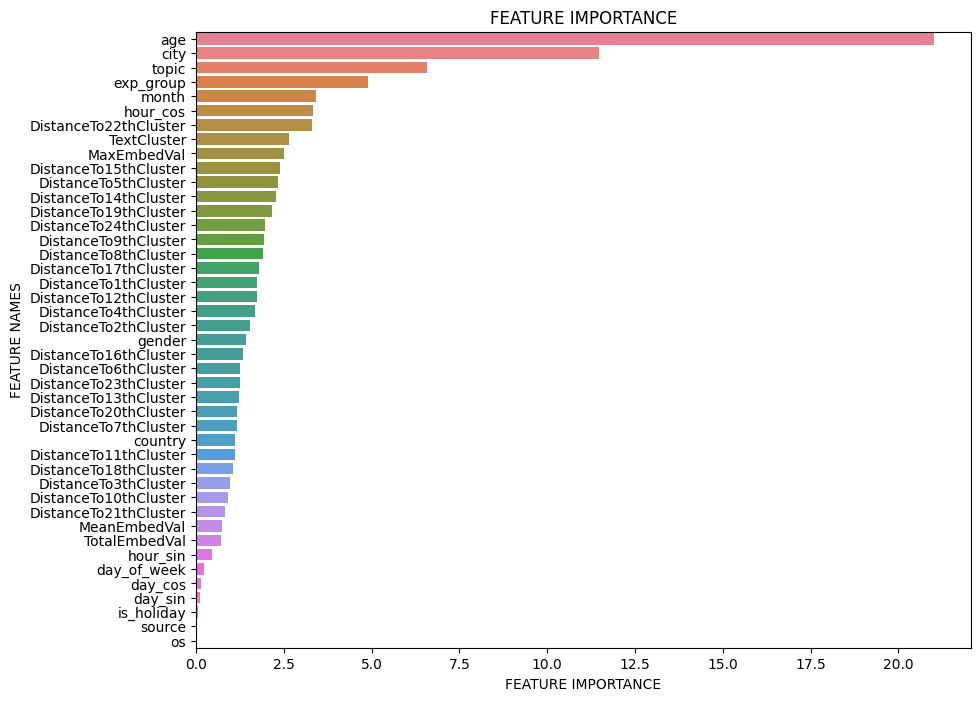

In [34]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], hue=fi_df['feature_names'])
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(cboost.feature_importances_, X_train.columns)

<b> Таким образом наиболее важными фичами для нашей модели оказались возраст, город и топик. В свою очередь тип операционной системы и источник трафика оказались наименее полезными. </b>